In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mbulsss/fakeavceleb-audio")
print("Path to dataset files:", path)

def find_file(root, filename):
    for r, _, files in os.walk(root):
        if filename in files:
            return os.path.join(r, filename)
    return None

def find_dir(root, dirname):
    for r, dirs, _ in os.walk(root):
        if dirname in dirs:
            return os.path.join(r, dirname)
    return None

# cari metadata dan folder melspec_windows_fixed di mana pun posisinya
train_csv = find_file(path, "metadata_train_identity.csv")
val_csv   = find_file(path, "metadata_val_identity.csv")
test_csv  = find_file(path, "metadata_test_identity.csv")
melspec_root = find_dir(path, "melspec_windows_fixed")

print("melspec_root:", melspec_root)
print("train_csv:", train_csv)
print("val_csv  :", val_csv)
print("test_csv :", test_csv)


Using Colab cache for faster access to the 'fakeavceleb-audio' dataset.
Path to dataset files: /kaggle/input/fakeavceleb-audio
melspec_root: /kaggle/input/fakeavceleb-audio/melspec_windows_fixed
train_csv: /kaggle/input/fakeavceleb-audio/metadata_train_identity.csv
val_csv  : /kaggle/input/fakeavceleb-audio/metadata_val_identity.csv
test_csv : /kaggle/input/fakeavceleb-audio/metadata_test_identity.csv


In [ ]:
import os
import pandas as pd

train_df = pd.read_csv(train_csv)
val_df   = pd.read_csv(val_csv)
test_df  = pd.read_csv(test_csv)

def smart_join(melspec_root, rel_path):
    rel_path = str(rel_path).replace("\\", "/")
    if rel_path.startswith("melspec_windows_fixed/"):
        rel_path = rel_path[len("melspec_windows_fixed/"):]
    return os.path.join(melspec_root, rel_path)

def fix_paths(df, melspec_root):
    df = df.copy()
    if "rel_path" in df.columns:
        df["path_fixed"] = df["rel_path"].apply(lambda p: smart_join(melspec_root, p))
    elif "path" in df.columns:
        df["path_fixed"] = df["path"]
    else:
        raise ValueError("CSV tidak punya kolom rel_path atau path")
    df["label"] = df["label"].astype(int)
    return df

train_df = fix_paths(train_df, melspec_root)
val_df   = fix_paths(val_df,   melspec_root)
test_df  = fix_paths(test_df,  melspec_root)

print("Train:", train_df.shape, "IDs:", train_df["identity_id"].nunique())
print("Val  :", val_df.shape,   "IDs:", val_df["identity_id"].nunique())
print("Test :", test_df.shape,  "IDs:", test_df["identity_id"].nunique())

Train: (63169, 7) IDs: 350
Val  : (13975, 7) IDs: 75
Test : (13962, 7) IDs: 75


In [ ]:
# CELL: CHECK DATAFRAME COLUMNS

print("\n CHECKING FOR LABEL COLUMNS:")
for col in train_df.columns:
    if 'label' in col.lower():
        print(f"  Found: {col}")
        print(f"    Unique values: {train_df[col].unique()}")
        print(f"    Value counts:")
        print(train_df[col].value_counts())



 CHECKING FOR LABEL COLUMNS:
  Found: label
    Unique values: [0 1]
    Value counts:
label
0    34587
1    28582
Name: count, dtype: int64


In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

class SpecAugment:
    def __init__(self, freq_mask_param=15, time_mask_param=20, n_freq_masks=2, n_time_masks=2):
        self.freq_mask_param = freq_mask_param
        self.time_mask_param = time_mask_param
        self.n_freq_masks = n_freq_masks
        self.n_time_masks = n_time_masks

    def __call__(self, mel):
        mel = mel.copy()
        n_mels, n_steps = mel.shape
        mu = mel.mean()

        for _ in range(self.n_freq_masks):
            f = np.random.randint(0, self.freq_mask_param + 1)
            if f == 0:
                continue
            f0 = np.random.randint(0, max(1, n_mels - f))
            mel[f0:f0+f, :] = mu

        for _ in range(self.n_time_masks):
            t = np.random.randint(0, self.time_mask_param + 1)
            if t == 0:
                continue
            t0 = np.random.randint(0, max(1, n_steps - t))
            mel[:, t0:t0+t] = mu

        return mel

class MelToXception:
    def __init__(self, augment=False):
        self.augment = augment
        self.spec_aug = SpecAugment() if augment else None

    def __call__(self, mel):
        if self.augment and self.spec_aug:
            mel = self.spec_aug(mel)

        mel_t = torch.from_numpy(mel).unsqueeze(0).unsqueeze(0).float()  # (1,1,128,T)
        mel_resized = F.interpolate(mel_t, size=(299, 299), mode="bilinear", align_corners=False)
        mel_resized = mel_resized.squeeze(0).squeeze(0)  # (299,299)

        mel_rgb = mel_resized.unsqueeze(0).repeat(3, 1, 1)  # (3,299,299)
        return mel_rgb

class AudioMetaDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        mel = np.load(row["path_fixed"])  # (128, T)

        if self.transform:
            mel = self.transform(mel)     # torch (3,299,299)

        label = torch.tensor(int(row["label"]), dtype=torch.long)
        clip_id = row["identity_id"] if "identity_id" in row else "NA"
        return mel, label, clip_id


In [ ]:
import os
from tqdm import tqdm

print("Indexing npy files under:", melspec_root)

npy_index = {}
dup = 0
total = 0

for root, _, files in os.walk(melspec_root):
    for f in files:
        if not f.endswith(".npy"):
            continue
        total += 1
        full = os.path.join(root, f)
        # keep track of the unique basename
        if f in npy_index:
            dup += 1
        else:
            npy_index[f] = full

print("Total npy:", total)
print("Unique basenames indexed:", len(npy_index))
print("Duplicates basenames:", dup)

import os

def mapping_by_basename(df):
    df = df.copy()
    # Extract basename
    df["basename"] = df["rel_path"].astype(str).apply(lambda p: os.path.basename(p.replace("\\","/")))
    # mapping ke path asli
    df["path_fixed"] = df["basename"].map(npy_index)
    # label int
    df["label"] = df["label"].astype(int)
    return df

train_df = mapping_by_basename(train_df)
val_df   = mapping_by_basename(val_df)
test_df  = mapping_by_basename(test_df)

print("Train:", len(train_df))
print("Val  :", len(val_df))
print("Test :", len(test_df))

# sanity check
print("Example fixed path:", train_df["path_fixed"].iloc[0])
print("Exists?", os.path.exists(train_df["path_fixed"].iloc[0]))

Indexing npy files under: /kaggle/input/fakeavceleb-audio/melspec_windows_fixed
Total npy: 91106
Unique basenames indexed: 78725
Duplicates basenames: 12381
Train: 63169
Val  : 13975
Test : 13962
Example fixed path: /kaggle/input/fakeavceleb-audio/melspec_windows_fixed/content/melspec_windows_fixed/FakeVideo-RealAudio/African/women/id02617/00028_win3.npy
Exists? True


In [ ]:
train_dataset = AudioMetaDataset(train_df, transform=MelToXception(augment=True))
val_dataset   = AudioMetaDataset(val_df,   transform=MelToXception(augment=False))
test_dataset  = AudioMetaDataset(test_df,  transform=MelToXception(augment=False))

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True,  num_workers=6, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=128, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset,  batch_size=128, shuffle=False, num_workers=4)

xb, yb, _ = next(iter(train_loader))
print("Batch:", xb.shape, yb.shape, yb[:10])


Batch: torch.Size([128, 3, 299, 299]) torch.Size([128]) tensor([0, 1, 0, 1, 0, 0, 1, 1, 1, 0])


In [ ]:
import timm
import torch.nn as nn

class AudioXceptionClassifier(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super().__init__()
        self.backbone = timm.create_model(
            "xception",
            pretrained=pretrained,
            num_classes=0
        )
        feat_dim = self.backbone.num_features

        self.classifier = nn.Sequential(
            nn.Linear(feat_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        feat = self.backbone(x)
        return self.classifier(feat)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = AudioXceptionClassifier().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

print("Model ready on", device)

/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth
Model ready on cuda


In [ ]:
from tqdm import tqdm
import torch

def train_one_epoch(model, loader):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    pbar = tqdm(loader, desc="Train", leave=False)
    for x, y, _ in pbar:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)

        pbar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{correct/total:.4f}")

    return total_loss / len(loader), correct / total


@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0

    pbar = tqdm(loader, desc="Val", leave=False)
    for x, y, _ in pbar:
        x, y = x.to(device), y.to(device)

        logits = model(x)
        loss = criterion(logits, y)

        total_loss += loss.item()
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)

        pbar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{correct/total:.4f}")

    return total_loss / len(loader), correct / total


In [ ]:
# Training
num_epochs = 15
patience = 7
best_val_acc = 0.0
patience_counter = 0

history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}


for epoch in range(1, num_epochs + 1):
    print(f" Epoch {epoch}/{num_epochs}")

    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc     = evaluate(model, val_loader)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"    Epoch {epoch} Summary:")
    print(f"   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"   Val Loss  : {val_loss:.4f} | Val Acc  : {val_acc:.4f}")

    # ReduceLROnPlateau expects metric value
    scheduler.step(val_loss)
    print(f"   Current LR: {optimizer.param_groups[0]['lr']:.6f}")

    # Early stopping + save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0

        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "val_loss": val_loss,
            "val_acc": val_acc,
        }, "best_audio_xception_identity.pth")

        print(f"   Best model saved! Val Acc: {val_acc:.4f}")
    else:
        patience_counter += 1
        print(f"   Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch}")
            print(f"Best Val Acc: {best_val_acc:.4f}")
            break

print(f"Best Validation Accuracy: {best_val_acc:.4f}")


 Epoch 1/15


    Epoch 1 Summary:
   Train Loss: 0.2221 | Train Acc: 0.9236
   Val Loss  : 0.1697 | Val Acc  : 0.9464
   Current LR: 0.001000
   Best model saved! Val Acc: 0.9464
 Epoch 2/15


    Epoch 2 Summary:
   Train Loss: 0.1952 | Train Acc: 0.9366
   Val Loss  : 0.1609 | Val Acc  : 0.9504
   Current LR: 0.001000
   Best model saved! Val Acc: 0.9504
 Epoch 3/15


    Epoch 3 Summary:
   Train Loss: 0.1931 | Train Acc: 0.9372
   Val Loss  : 0.1706 | Val Acc  : 0.9481
   Current LR: 0.001000
   Patience: 1/7
 Epoch 4/15


    Epoch 4 Summary:
   Train Loss: 0.1894 | Train Acc: 0.9390
   Val Loss  : 0.1606 | Val Acc  : 0.9499
   Current LR: 0.001000
   Patience: 2/7
 Epoch 5/15


    Epoch 5 Summary:
   Train Loss: 0.1896 | Train Acc: 0.9385
   Val Loss  : 0.1630 | Val Acc  : 0.9496
   Current LR: 0.001000
   Patience: 3/7
 Epoch 6/15


    Epoch 6 Summary:
   Train Loss: 0.1889 | Train Acc: 0.9386
   Val Loss  : 0.1628 | Val Acc  : 0.9498
   Current LR: 0.001000
   Patience: 4/7
 Epoch 7/15


    Epoch 7 Summary:
   Train Loss: 0.1878 | Train Acc: 0.9395
   Val Loss  : 0.1615 | Val Acc  : 0.9503
   Current LR: 0.001000
   Patience: 5/7
 Epoch 8/15


    Epoch 8 Summary:
   Train Loss: 0.1882 | Train Acc: 0.9390
   Val Loss  : 0.1615 | Val Acc  : 0.9504
   Current LR: 0.000500
   Patience: 6/7
 Epoch 9/15


    Epoch 9 Summary:
   Train Loss: 0.1840 | Train Acc: 0.9405
   Val Loss  : 0.1616 | Val Acc  : 0.9500
   Current LR: 0.000500
   Patience: 7/7

Early stopping triggered at epoch 9
Best Val Acc: 0.9504
Best Validation Accuracy: 0.9504


In [ ]:
import torch

ckpt_path = "/content/drive/MyDrive/deepfake_checkpoints/Multi Modal/best_audio_xception.pth"  # sesuaikan kalau beda
checkpoint = torch.load(ckpt_path, map_location=device)

# kalau kamu save dict (epoch, state_dict, dll)
if isinstance(checkpoint, dict) and "model_state_dict" in checkpoint:
    model.load_state_dict(checkpoint["model_state_dict"])
else:
    # kalau kamu save langsung model.state_dict()
    model.load_state_dict(checkpoint)

model.to(device)
model.eval()
print("Loaded checkpoint:", ckpt_path)


✅ Loaded checkpoint: /content/drive/MyDrive/deepfake_checkpoints/Multi Modal/best_audio_xception.pth


In [ ]:
import numpy as np
from tqdm import tqdm
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score
)

all_labels = []
all_preds  = []
all_probs  = []
all_ids    = []

with torch.no_grad():
    for x, y, ids in tqdm(test_loader, desc="Testing"):
        x = x.to(device)
        y = y.to(device)

        logits = model(x)                          # [B,2]
        probs = torch.softmax(logits, dim=1)[:, 1] # prob FAKE
        preds = torch.argmax(logits, dim=1)

        all_labels.extend(y.cpu().numpy().tolist())
        all_preds.extend(preds.cpu().numpy().tolist())
        all_probs.extend(probs.cpu().numpy().tolist())
        all_ids.extend(list(ids))

all_labels = np.array(all_labels)
all_preds  = np.array(all_preds)
all_probs  = np.array(all_probs)

acc = (all_preds == all_labels).mean()
cm = confusion_matrix(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_probs)

print("\nTEST RESULTS")
print("Accuracy:", acc)
print("AUC     :", auc)
print("\nCONFUSION MATRIX [ [TN FP], [FN TP] ]")
print(cm)

print("\nCLASSIFICATION REPORT")
print(classification_report(all_labels, all_preds, target_names=["REAL(0)", "FAKE(1)"]))


Testing: 100%|██████████| 110/110 [00:18<00:00,  5.90it/s]


TEST RESULTS
Accuracy: 0.9434894714224323
AUC     : 0.9514878743984505

CONFUSION MATRIX [ [TN FP], [FN TP] ]
[[6763  789]
 [   0 6410]]

CLASSIFICATION REPORT
              precision    recall  f1-score   support

     REAL(0)       1.00      0.90      0.94      7552
     FAKE(1)       0.89      1.00      0.94      6410

    accuracy                           0.94     13962
   macro avg       0.95      0.95      0.94     13962
weighted avg       0.95      0.94      0.94     13962



# **=========================**

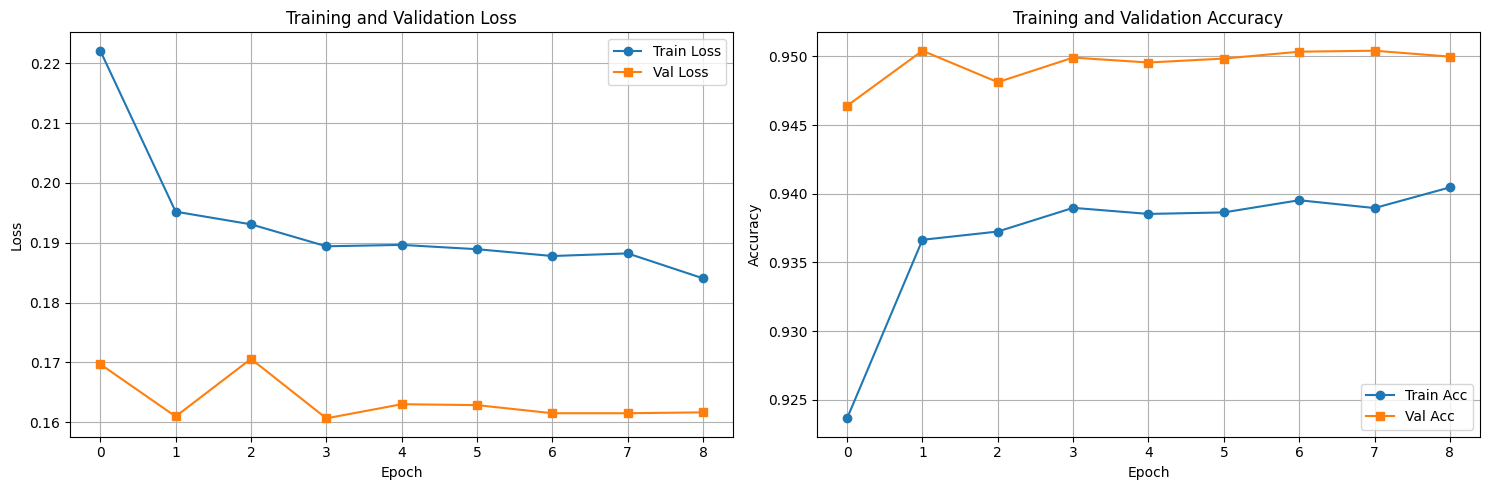

📈 Training history plot saved!


In [ ]:
# Plot training history
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy
axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("📈 Training history plot saved!")